In [489]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

# Polynomial regression - LS vs MLE

### Selecting model-order and Generating data
Here we will generate a synthetic dataset from a n-th order polynomial model **$y = \theta_0  + \theta_1 \cdot u^1 + ... + \theta_n \cdot u^n $** and add some noise, with known distribution, to simulate sampling of the data, giving us **$y_{measured} = y + noise$**,  where:  
$y$ = output  
$u$ = input    
$\theta_{0,1,...,n}$ = model parameters   
$noise$ = measurement noise

Given the genreated input data $u$ and the measured data **$y_{measured}$** we will try to estimate the polynomial model coeffitienst $\hat{\theta}_{0,1,...,n}$ using the Least sqaures (LS) and Maximum likelihood estimate (MLE) methods.

### Model-order selection 
The "params" vector decides the order of the selected model, make sure to put in \$n+1\$ parameters into the vector for the get a model of order \$n\$, the first parameter \$\theta_0\$ is the bias term

In [1]:
def arbitrary_poly(params):
    poly_model = lambda x: sum([p*(x**i) for i, p in enumerate(params)])
    return poly_model

# params: [theta_0, theta_1, ... , theta_n], where n = model order and theta_0 is bias 
true_params = [1,-8,4]
y_model = arbitrary_poly(true_params)

# Plot true model
x = np.linspace(start=0, stop=3, num=100)
plt.figure()
plt.plot(x, y_model(x))
plt.xlabel("x")
plt.ylabel("y")
plt.title("Model");

NameError: name 'np' is not defined

### Measurement noise generation from a chosen distribution
Probability density functions (PDFs):

Gaussian pdf: $P(x) = \frac{1}{\sigma\sqrt{2\pi}}e^{-\frac{1}{2}(\frac{x-\mu}{\sigma})^2}$

Laplacian pdf: $P(x) = \frac{1}{2b}e^{-\frac{|x-\mu|}{b}}$

Hyperparameters to adjust:
- dist: "laplace" or "gauss" : the class of noise-generating distribution.
- mu: The distribution's location parameter (mean value for Gauss).
- sigma: The distribution's scaling parameter (std. for Gauss).
- magnitude: The noise magnitude.
- N: number of samples to generate for the model.

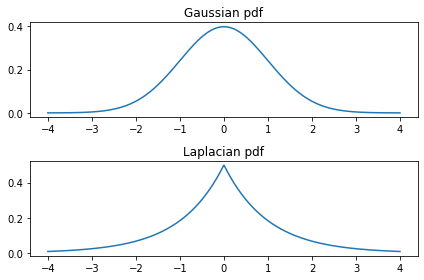

In [734]:
# Hyperparameters for the type of noise-generating distribution.
dist = "gauss"  # choose between "laplace" or "gauss"
loc = 0           # location (mean) parameter 
scale = 1         # scaling (std dev) parameter
magnitude = 1.2   # noise magnitude
N = 200           # number of samples

np.random.seed(123)  # Non-random generation between code executions. Comment out for true random

# The Laplace probability density function:
# Also available in library "scipy.stats.laplace"
def laplace_pdf(x, loc, scale):
    return (1.0/(2.0 * scale)) * np.exp( -np.abs(x-loc) / scale)

# The Gaussian probability density function:
# Also available in library "scipy.stats.norm"
def gauss_pdf(x, loc, scale):
    return 1.0/(scale * np.sqrt(2.0 * np.pi)) * np.exp( -0.5 * ((x - loc) / scale)**2 )

# Plot pdfs:
fig, [ax0, ax1] = plt.subplots(2)

n = np.linspace(start=(loc - 4*scale), stop=(loc + 4*scale), num=1000)  # input range centered around mean of pdf
ax0.plot(n, gauss_pdf(n, loc, scale))
ax0.set_title('Gaussian pdf')
ax1.plot(n,laplace_pdf(n, loc, scale))
ax1.set_title('Laplacian pdf')
plt.tight_layout()
plt.show()

### Data generation:

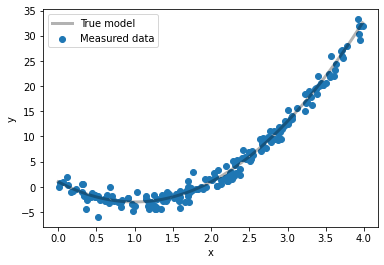

In [735]:
# Generate data points
range_low = 0
range_high = 4
u = np.sort(np.random.uniform(range_low,range_high,N))
y_true = y_model(u)

# Generate noise
from scipy.stats import norm, laplace
if dist == "laplace":
    #pdf = laplace_pdf
    pdf = laplace.pdf
    noise = magnitude * np.random.laplace(loc, scale, N)
elif dist == "gauss":
    #pdf = gauss_pdf
    pdf = norm.pdf
    noise = magnitude * np.random.normal(loc, scale, N)
else:
    raise Exception("Distribution not implemented, choose \"laplace\" or \"gauss\"")

# Add noise to the generated data points - thus simulating measurement
y = y_true + noise

# Plot measured data
plt.scatter(u, y, label=r"Measured data")
u0 = np.linspace(0, max(u), N)
plt.plot(u0, y_model(u0), "k", alpha=0.3, lw=3, label="True model")
plt.legend()
plt.xlabel("x")
plt.ylabel("y");

## Least squares regression - LS
### Given the sampled data we can estimate the underlying polynomial model using LS regression
Solution to a least squares problem is given by the normal equation:  
$\hat{\mathbf{\theta}} = (\mathbf{u}^T\cdot \mathbf{u})^{-1}(\mathbf{u}^T\cdot \mathbf{y})$

### Step 1 - rewrite the model in matrix form to get the data tensor u
$y_{measured} = \theta_0  + \theta_1 \cdot u^1 + ... + \theta_n \cdot u^n  + noise =   [1 \; u^1 \; .. \; u^n] \cdot [ \theta_0 \; \theta_1 \; .. \; \theta_n ] ^T + noise$

$\mathbf{u} = [1 \; u^1 \; .. \; u^n]$

In [736]:
# Matrix form
u_tensor_0 = np.reshape(u,(N,1))
print(f"data u :\n{u_tensor_0[0:5]} \n")

ones_vec = np.ones((N,1))
u_tensor = np.append(ones_vec, u_tensor_0, axis=1)

for i in range(2,len(true_params)):
    u_tensor = np.append(u_tensor, np.power(u_tensor_0, i) ,axis=1)

print(f"data tensor [1, u, u^2, ... , u^n] :\n{u_tensor[0:5,:]}")

data u :
[[0.01075226]
 [0.02970551]
 [0.06451683]
 [0.11727889]
 [0.12879174]] 

data tensor [1, u, u^2, ... , u^n] :
[[1.00000000e+00 1.07522583e-02 1.15611058e-04]
 [1.00000000e+00 2.97055142e-02 8.82417573e-04]
 [1.00000000e+00 6.45168268e-02 4.16242094e-03]
 [1.00000000e+00 1.17278892e-01 1.37543384e-02]
 [1.00000000e+00 1.28791740e-01 1.65873122e-02]]


### Step 2   

calculate $(\mathbf{u}^T \cdot \mathbf{u})^{-1}$

In [737]:
u_transpose_dot_u = np.dot(u_tensor.T,u_tensor)  # calculating dot product
u_transpose_dot_u_inv = np.linalg.inv(u_transpose_dot_u) #calculating inverse
print(u_transpose_dot_u_inv)

[[ 0.05424037 -0.05321654  0.01117055]
 [-0.05321654  0.0671349  -0.01580994]
 [ 0.01117055 -0.01580994  0.00398592]]


### Step 3  

calculate $(\mathbf{u}^T \cdot \mathbf{y})$

In [738]:
u_transpose_dot_y = np.dot(u_tensor.T,y)  # calculating dot product
print(u_transpose_dot_y)

[ 1095.6940978   3973.20430355 13684.58520515]


### Step 4 

solve for $\hat{\mathbf{\theta}} = (\mathbf{u}^T\cdot \mathbf{u})^{-1}(\mathbf{u}^T\cdot \mathbf{y})$

LS parameters:         ['0.85', '-7.92', '3.97']
True model parameters: [1, -8, 4]


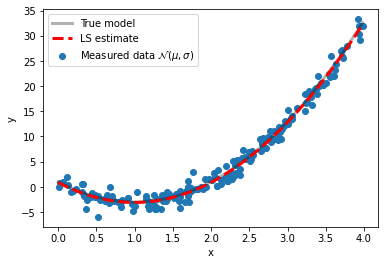

In [739]:
LS_params = np.dot(u_transpose_dot_u_inv,u_transpose_dot_y)
LS_params_rounded = ["{:.2f}".format(round(i, 2)) for i in LS_params.tolist()]
print(f"LS parameters:         {LS_params_rounded}")
print(f"True model parameters: {true_params}")

# Recreate model based on LS estimate:
LS_params = LS_params.tolist()
LS_estimate = arbitrary_poly(LS_params)

# Plot true vs. estimated model
plt.scatter(u, y, label=r"Measured data $\mathcal{N}(\mu, \sigma)$")
u0 = np.linspace(0, max(u), N)
plt.plot(u0, y_model(u0), "k", alpha=0.3, lw=3, label="True model")
plt.plot(u0, LS_estimate(u0), "r--",  lw=3, label="LS estimate")
#plt.xlim(0, 10)
plt.legend()
plt.xlabel("x")
plt.ylabel("y");

## Maximum likelihood estimation regression - MLE
In the special case where the sampled data and the measurement noise are normally distributed
the MLE solution is equal to the LS solution, the code below solves the presented first order regression problem using maximum liklihood estimation.

Source: http://web.vu.lt/mif/a.buteikis/wp-content/uploads/PE_Book/3-4-UnivarMLE.html

### Step 1 - define the log likelihood function to be minimized

In [740]:
def log_lik(par_vec, y, x):
    global pdf  # Use the distribution class chosen earlier
    # If the standard deviation parameter is negative, return a large value:
    if par_vec[-1] < 0:
        return(1e8)
    # The likelihood function values:
    lik = pdf(y,
              loc = sum([p*(x**i) for i, p in enumerate(par_vec[:-1])]),
              scale = par_vec[-1])
    
    #This is similar to calculating the likelihood for Y - XB
    # res = y - par_vec[0] - par_vec[1] * x
    # lik = norm.pdf(res, loc = 0, sd = par_vec[2])
    
    # If all logarithms are zero, return a large value
    if all(v == 0 for v in lik):
        return(1e8)
    # Logarithm of zero = -Inf
    return(-sum(np.log(lik[np.nonzero(lik)])))

### Step 2 - use optimization solver to fit the data to the likelihood function

In [741]:
import scipy.optimize as optimize

# The likelihood function includes the scale (std dev) parameter which is also estimated by the optimized
# therefore the initial guess verctor has length n+2 [theta_0_hat, theta_1_hat, ... , theta_n_hat, sigma_hat]
init_guess = np.zeros(len(true_params)+1)
init_guess[-1] = N

# Do Maximum Likelihood Estimation:
opt_res = optimize.minimize(fun = log_lik,
                            x0 = init_guess,
                            options={'disp': True},
                            args = (y, u))

MLE_params = opt_res.x[:-1]
MLE_estimate = arbitrary_poly(MLE_params)

MLE_params_rounded = ["{:.2f}".format(round(i, 2)) for i in MLE_params.tolist()]
print(f"\nMLE parameters:        {MLE_params_rounded}")
print(f"True model parameters: {true_params}")

         Current function value: 310.199498
         Iterations: 40
         Function evaluations: 385
         Gradient evaluations: 77

MLE parameters:        ['0.85', '-7.92', '3.97']
True model parameters: [1, -8, 4]


## Comparing LS & MLE

LS parameters:   ['0.85', '-7.92', '3.97']
MLE parameters:  ['0.85', '-7.92', '3.97']
True parameters: [1, -8, 4]


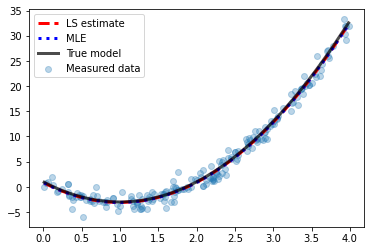

In [742]:
print(f"LS parameters:   {LS_params_rounded}")
print(f"MLE parameters:  {MLE_params_rounded}")
print(f"True parameters: {true_params}")

# Recreate model based on LS estimate:
plt.figure()
plt.scatter(u, y, alpha=0.3, label=r"Measured data")
plt.plot(u, LS_estimate(u), "r--",  lw=3, label="LS estimate")
plt.plot(u, MLE_estimate(u), "b:",  lw=3, label="MLE")
plt.plot(u, y_model(u), "k", alpha=0.7, lw=3, label="True model")
plt.legend();

### Calculating (Root mean square error) RMSE for LS and MLE

**RMSE** = $\sqrt{\frac{1}{n}\Sigma_{i=1}^{n}{\big({\hat{y}_i - y_{i}}\big)^2}}$

In [743]:
print(f"LS - RMSE:  {np.sqrt(np.mean((LS_estimate(u)-y)**2))}")
print(f"MLE - RMSE: {np.sqrt(np.mean((MLE_estimate(u)-y)**2))}")

LS - RMSE:  1.1411755964386383
MLE - RMSE: 1.141175596438642
